In [1]:
from diffusion_lattice import *

# device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cpu'
print(f"Using device: {device}")

Using device: cpu


In [2]:
lattice_size = 32
train_data = generate_training_data(
            lattice_size=lattice_size,
            num_samples=10000,
            m2=-0.2,
            g=0.2,
            num_chains=128
        ).to(device)

Generating 10000 training samples using 128 chains...
Using sample spacing of 50 based on autocorrelation time
Acceptance rate: 0.402


In [3]:
diffusion = setup_diffusion_model(
        lattice_size=lattice_size,
        base_dim=16,
        dim_mults=(1, 2, 4, 8),
        timesteps=100,
        objective='pred_v'
    ).to(device)

In [5]:
def count_parameters(model):
    """
    Count the number of parameters in a PyTorch model.
    
    Args:
        model (torch.nn.Module): The model to count parameters for.
        
    Returns:
        int: The total number of parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Example usage
diffusion = setup_diffusion_model(
    lattice_size=32,
    base_dim=16,
    dim_mults=(1, 2, 4),
    timesteps=200,
    objective='pred_v'
)

num_params = count_parameters(diffusion)
print(f"Number of parameters in the diffusion model: {num_params}")

Number of parameters in the diffusion model: 381665


In [23]:
trainer, dataset = train_diffusion_model(
            diffusion=diffusion,
            train_data=train_data,
            batch_size=64,
            learning_rate=2e-4,
            num_epochs=400,
            save_dir="./results"
        )

Training diffusion model...


  0%|          | 0/400 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

training complete


In [24]:
# # Load pre-trained model
# pretrained_location = 'results/model-10.pt'
# print(f"Loading pre-trained model from {pretrained_location}")

# # Load the entire checkpoint
# checkpoint = torch.load(pretrained_location, map_location=device)

# # Extract just the model state dictionary
# if isinstance(checkpoint, dict) and "model" in checkpoint:
#     model_state = checkpoint["model"]
#     # If model is itself a dict with state_dict
#     if isinstance(model_state, dict) and "state_dict" in model_state:
#         model_state = model_state["state_dict"]
    
#     # Load the model state dictionary
#     diffusion.load_state_dict(model_state)
#     print("Model loaded successfully!")
# else:
#     print("Error: Unexpected checkpoint format")
#     print("Keys in checkpoint:", checkpoint.keys() if isinstance(checkpoint, dict) else "Not a dictionary")

In [25]:
num_samples = 256
generated_samples = sample_from_model(
        diffusion=diffusion,
        num_samples=num_samples,
        batch_size=128,
        device=device,
        data_max=dataset.data_max,
        data_min=dataset.data_min
    )

Generating 256 samples from diffusion model...


sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

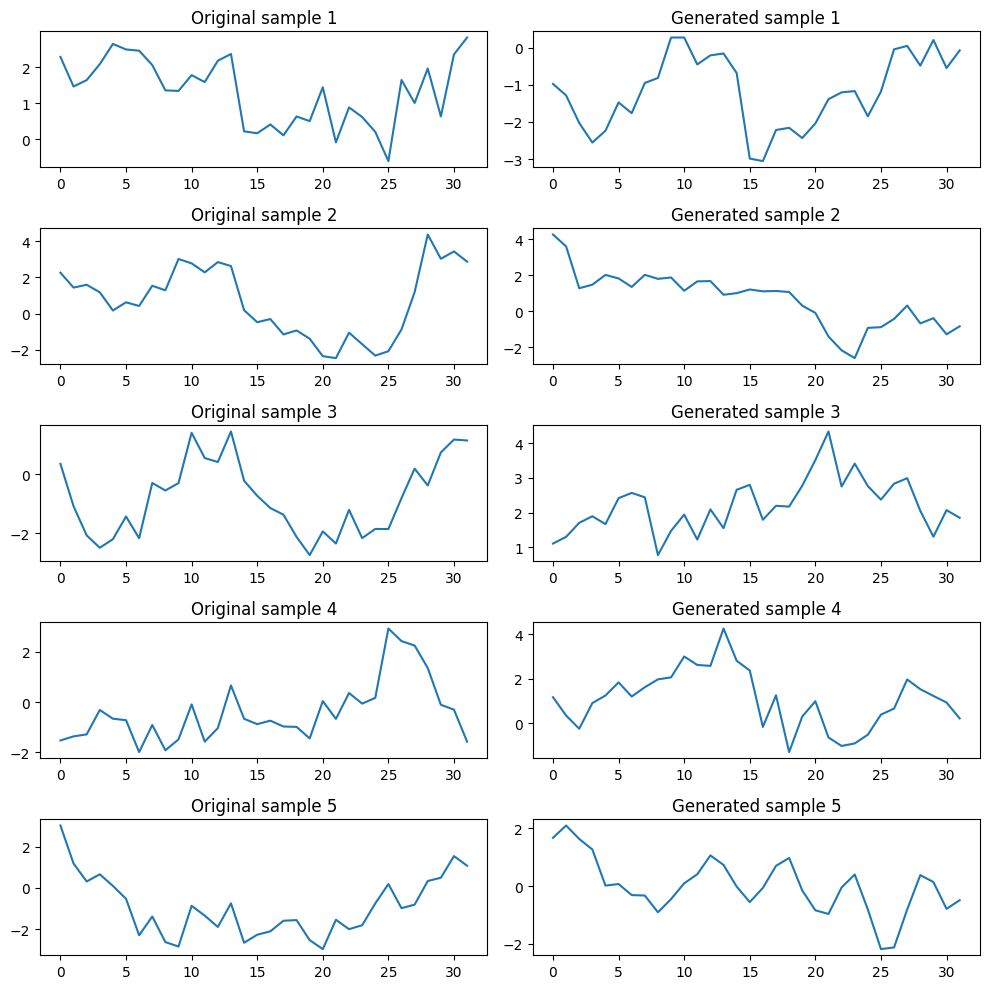

In [26]:
train_data_cpu = train_data.cpu()
plot_num = 5
plot_samples(
        original_samples=train_data_cpu[:plot_num],
        generated_samples=generated_samples[:plot_num],
        num_to_plot=plot_num
    )

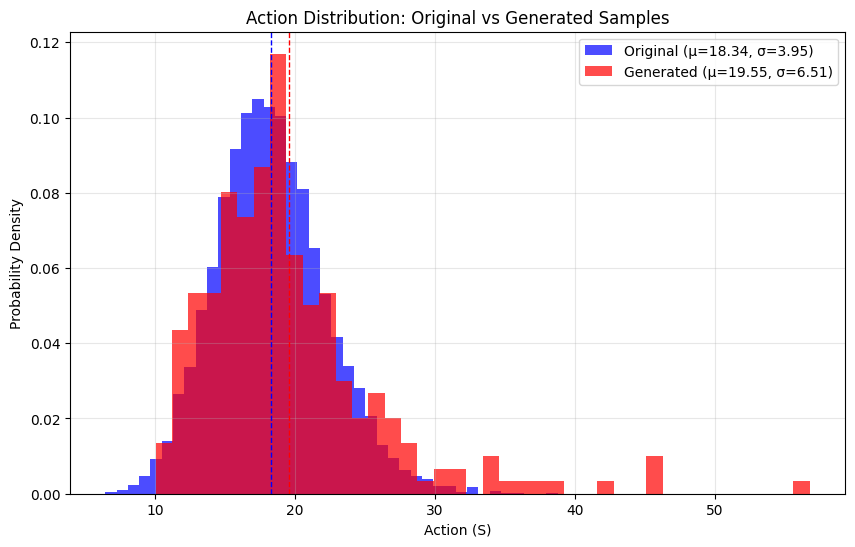

Original samples: Mean=18.3372, Std=3.9486
Generated samples: Mean=19.5543, Std=6.5056


In [27]:
from action_histogram2 import compare_action_distributions

# Ensure you have original and generated samples ready
# We'll use a smaller subset for faster computation
num_samples_to_compare = num_samples
original_subset = train_data_cpu
generated_subset = generated_samples[:num_samples_to_compare]

# Compare action distributions using the same parameters used for training
stats = compare_action_distributions(
    original_samples=original_subset,
    generated_samples=generated_subset,
    m2=-0.2,  # Use the same m2 value used for training
    g=0.2,    # Use the same g value used for training
    bins=40,
    title="Action Distribution: Original vs Generated Samples",
    save_path="action_comparison.png"  # Optional
)